In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Классификация объявлений о работе на реальные и мошеннические

Датасет содержит описание множества вакансий о работе. Среди вакансий могут быть как настоящие посты, так и мошеннические. Требуется определять по описания является ли вакансия настоящей или мошеннической.

In [2]:
data_raw = pd.read_csv("/home/zorin_o/oleg-w570/real-or-fake-job-posting/fake_job_postings.csv")

## Поверхностный обзор

Обзор признаков:
1. `job_id` - Уникальный идентификатор работы
2. `title` - Название объявления о вакансии.
3. `location` - Географическое местоположение объявления о вакансии.
4. `department` - Корпоративный отдел (например, отдел продаж).
5. `salary_range` - Ориентировочный диапазон заработной платы (например, 50 000–60 000 долларов США)
6. `company_profile` - Краткое описание компании.
7. `description` - Подробное описание вакансии.
8. `requirements` - Перечислены требования к вакансии.
9. `benefits` - Работодатель предлагает рядовым военнослужащим льготы.
10. `telecommuting` - Удаленная работа или нет.
11. `has_company_logo` - Присутствует ли логотип компании.
12. `has_questions` - Присутствуют ли контрольные вопросы.
13. `employment_type` - Полная занятость, неполный рабочий день, контракт и т. д.
14. `required_experience` - Руководитель, Начальный уровень, Стажер и т.д.
15. `required_education` - Докторантура, магистр, бакалавр и т.д.
16. `industry` - Автомобилестроение, ИТ, здравоохранение, недвижимость и т. д.
17. `function` - Консалтинг, инжиниринг, исследования, продажи и т. д.
18. `fraudulent` - Мошенническое ли объявление (целевая переменная).

In [3]:
data_raw.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


Объём данных: $N = 17880$

Число признаков: $d = 18$

Количество классов: $K = 2$

In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

Можно заметить, что среди нескольких признаков есть пропуски, причём некоторые в значительном количестве. Первый признак `job_id` является уникальным индетификатором вакансии на площадке, поэтому целесообразно будет сразу убрать его, так как он не принесёт пользы в решении задачи.  

In [5]:
data = data_raw.drop(columns=["job_id"])

## Обработка признаков

### Признак `location`

In [6]:
data.location.unique()

array(['US, NY, New York', 'NZ, , Auckland', 'US, IA, Wever', ...,
       'US, CA, los Angeles', 'CA, , Ottawa', 'GB, WSX, Chichester'],
      dtype=object)

In [7]:
data.location.isna().sum()

346

Локация представляет из себя набор: страна, штат (область), город. Кажется целесообразным разделить это на три отдельных признака. Они будут категориальными. Также присутствуют пропущенные значения как в целом, так и отдельно. Для них будем указывать, что информация не предоставлена. 

In [8]:
location_columns = ["country", "state", "city"]

data[location_columns] = data["location"].str.split(",", n=2, expand=True)

for col in location_columns:
    data[col] = data[col].fillna("Unspecified")
    data[col] = data[col].replace(" ", "Unspecified")
    data[col] = data[col].str.strip()
    data[col] = data[col].str.lower()

data = data.drop(columns=["location"])

data[location_columns] = data[location_columns].astype("category")

Получили следующее:

In [9]:
data.country.unique()

['us', 'nz', 'de', 'gb', 'au', ..., 'ni', 'lk', 'jm', 'kz', 'kh']
Length: 91
Categories (91, object): ['ae', 'al', 'am', 'ar', ..., 'vi', 'vn', 'za', 'zm']

In [10]:
data.state.unique()

['ny', 'unspecified', 'ia', 'dc', 'fl', ..., 'der', 'iow', 'dud', 'sn', 'nle']
Length: 325
Categories (325, object): ['00', '01', '02', '03', ..., 'wy', 'yor', 'zet', 'zh']

In [11]:
data.city.unique()

['new york', 'auckland', 'wever', 'washington', 'fort worth', ..., 'sacremento', 'meridian', 'slidell', 'silicon valley/san jose - santa clara', 'berkeley heights']
Length: 2082
Categories (2082, object): ['', '02139', '04102', '10010', ..., 'αthens', 'αθήνα', 'ελληνικο', '마포구 동교동']

### Бинарные признаки

In [12]:
binary_columns = ["telecommuting", "has_company_logo", "has_questions"]

data[binary_columns] = data[binary_columns].astype("category")

In [13]:
data[binary_columns].isna().sum()

telecommuting       0
has_company_logo    0
has_questions       0
dtype: int64

In [14]:
for col in binary_columns:
    print(col.upper())
    print(data[col].unique(), "\n")

TELECOMMUTING
[0, 1]
Categories (2, int64): [0, 1] 

HAS_COMPANY_LOGO
[1, 0]
Categories (2, int64): [0, 1] 

HAS_QUESTIONS
[0, 1]
Categories (2, int64): [0, 1] 



### Остальные категориальные признаки

In [15]:
other_columns = [
    "department",
    "salary_range",
    "employment_type",
    "required_experience",
    "required_education",
    "industry",
    "function",
]

data[other_columns] = data[other_columns].fillna("Unspecified")
data[other_columns] = data[other_columns].replace(" ", "Unspecified")

for col in other_columns:
    data[col] = data[col].str.strip()
    data[col] = data[col].str.lower()

data[other_columns] = data[other_columns].astype("category")

In [16]:
for col in other_columns:
    print(col.upper())
    print(data[col].unique(), "\n")

DEPARTMENT
['marketing', 'success', 'unspecified', 'sales', 'androidpit', ..., 'hotel jobs', 'data entry, clerical admin, administrative as..., 'user experience design', 'admin - clerical', 'administrative dept']
Length: 1224
Categories (1224, object): ['(consultant)', '.net', '.net development', '0', ..., 'youth health clinic', 'área comercial', 'εμπορικο', 'πληροφορικη'] 

SALARY_RANGE
['unspecified', '20000-28000', '100000-120000', '120000-150000', '50000-65000', ..., '21-31', '48000-65000', '53000-67000', '22-61000', '3700-3800']
Length: 875
Categories (875, object): ['0-0', '0-1', '0-1000', '0-100000', ..., 'jun-18', 'oct-15', 'oct-20', 'unspecified'] 

EMPLOYMENT_TYPE
['other', 'full-time', 'unspecified', 'part-time', 'contract', 'temporary']
Categories (6, object): ['contract', 'full-time', 'other', 'part-time', 'temporary', 'unspecified'] 

REQUIRED_EXPERIENCE
['internship', 'not applicable', 'unspecified', 'mid-senior level', 'associate', 'entry level', 'executive', 'director'

### Кодирование признаков

In [17]:
category_columns = data.select_dtypes(include="category").columns
print(category_columns)

Index(['department', 'salary_range', 'telecommuting', 'has_company_logo',
       'has_questions', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'country', 'state',
       'city'],
      dtype='object')


## Текстовые признаки

In [18]:
text_columns = data.select_dtypes(include="object").columns
print(text_columns)

Index(['title', 'company_profile', 'description', 'requirements', 'benefits'], dtype='object')


In [19]:
data[text_columns] = data[text_columns].fillna("")
data["combined_text"] = data[text_columns].agg(" ".join, axis=1)

In [20]:
import re


def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text


data["combined_text"] = data["combined_text"].apply(clean_text)

## Разделение на тренировочную и тестовую выборки

In [21]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=["fraudulent"])
y = data["fraudulent"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Преобразование признаков

In [22]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown="ignore")
X_train_category = encoder.fit_transform(X_train[category_columns])
X_test_category = encoder.transform(X_test[category_columns])

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_text = vectorizer.fit_transform(X_train["combined_text"])
X_test_text = vectorizer.transform(X_test["combined_text"])

In [24]:
from scipy.sparse import hstack

X_train = hstack([X_train_category, X_train_text])
X_test = hstack([X_test_category, X_test_text])

## Обучение моделей без балансировки классов

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


models = {
    "Logistic Regression": {
        "model": LogisticRegression(n_jobs=-1),
        "pred": None,
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(n_jobs=-1),
        "pred": None,
    },
    "Random Forest": {
        "model": RandomForestClassifier(n_jobs=-1),
        "pred": None,
    },
    "SVM": {
        "model": SVC(),
        "pred": None,
    },
}

for name, model in models.items():
    model["model"].fit(X_train, y_train)
    model["pred"] = model["model"].predict(X_test)

LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.93      0.62      0.74       181

    accuracy                           0.98      3576
   macro avg       0.96      0.81      0.87      3576
weighted avg       0.98      0.98      0.98      3576
 

K-NEAREST NEIGHBORS
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3395
           1       0.83      0.69      0.76       181

    accuracy                           0.98      3576
   macro avg       0.91      0.84      0.87      3576
weighted avg       0.98      0.98      0.98      3576
 

RANDOM FOREST
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       1.00      0.60      0.75       181

    accuracy                           0.98      3576
   macro avg       0.99      0.80      0.87      3576
weighted avg    

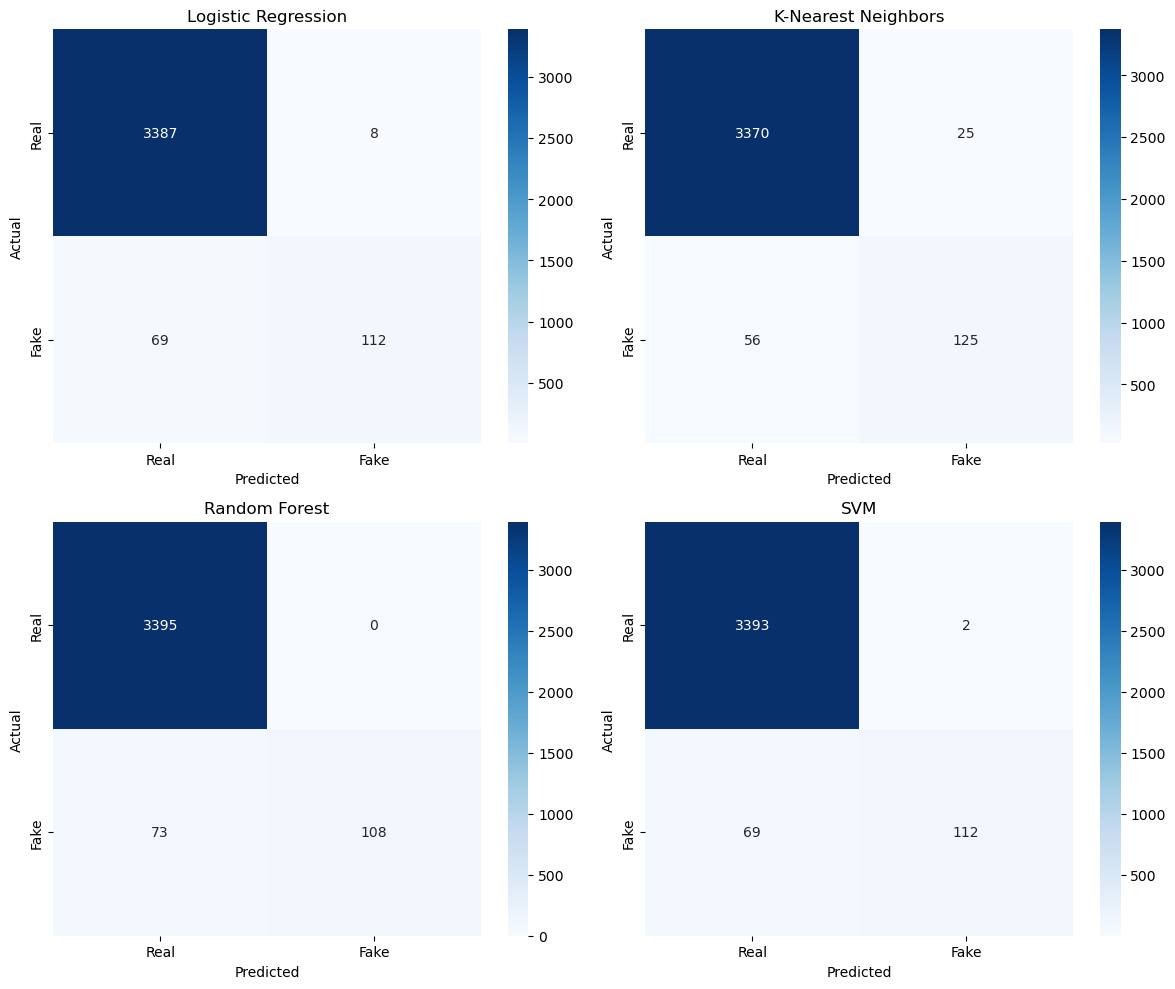

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, model) in zip(axes.ravel(), models.items()):
    print(name.upper())
    print(classification_report(y_test, model["pred"]), "\n")

    cm = confusion_matrix(y_test, model["pred"])
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        ax=ax,
        xticklabels=["Real", "Fake"],
        yticklabels=["Real", "Fake"],
        cmap="Blues",
    )
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()

## Борьба с несбалансированностью классов

In [27]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

## Обучение моделей с сбалансированными классами

In [28]:
models = {
    "Logistic Regression": {
        "model": LogisticRegression(n_jobs=-1),
        "pred": None,
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(n_jobs=-1),
        "pred": None,
    },
    "Random Forest": {
        "model": RandomForestClassifier(n_jobs=-1),
        "pred": None,
    },
    "SVM": {
        "model": SVC(),
        "pred": None,
    },
}

for name, model in models.items():
    model["model"].fit(X_train, y_train)
    model["pred"] = model["model"].predict(X_test)

LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3395
           1       0.71      0.88      0.79       181

    accuracy                           0.98      3576
   macro avg       0.85      0.93      0.89      3576
weighted avg       0.98      0.98      0.98      3576
 

K-NEAREST NEIGHBORS
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      3395
           1       0.31      0.95      0.47       181

    accuracy                           0.89      3576
   macro avg       0.66      0.92      0.71      3576
weighted avg       0.96      0.89      0.92      3576
 

RANDOM FOREST
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.98      0.67      0.80       181

    accuracy                           0.98      3576
   macro avg       0.98      0.84      0.90      3576
weighted avg    

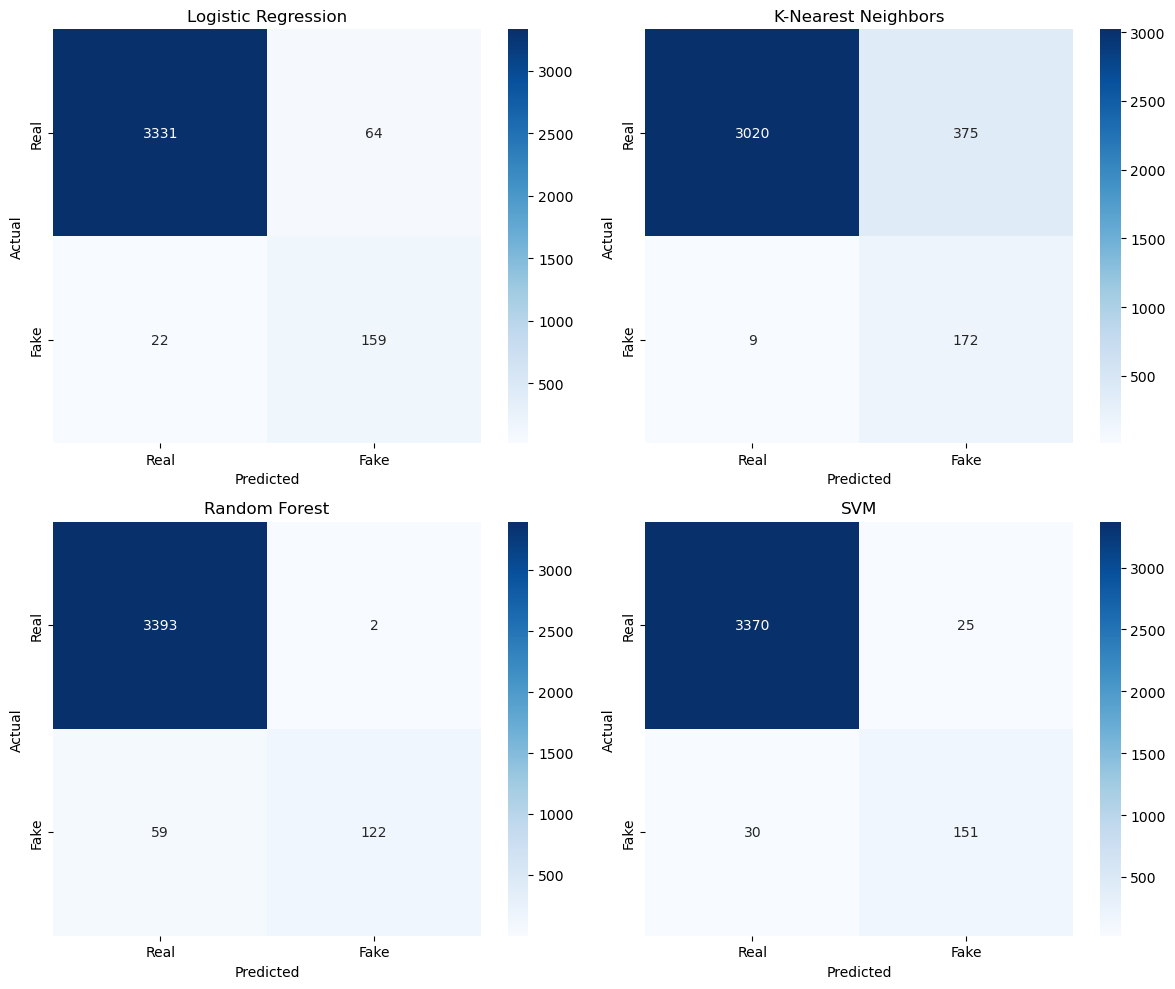

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, model) in zip(axes.ravel(), models.items()):
    print(name.upper())
    print(classification_report(y_test, model["pred"]), "\n")

    cm = confusion_matrix(y_test, model["pred"])
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        ax=ax,
        xticklabels=["Real", "Fake"],
        yticklabels=["Real", "Fake"],
        cmap="Blues",
    )
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()

## Подбор гиперпараметров

In [ ]:
# from sklearn.model_selection import GridSearchCV


# param_grid = {'C': [0.1, 1, 10, 100, 1000],
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf','linear']}

# grid_search = GridSearchCV(SVC(), param_grid, n_jobs=-1)

# grid_search.fit(X_train, y_train)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']})

In [ ]:
# print("Подобранные лучшие параметры: ", grid_search.best_params_)

Подобранные лучшие параметры:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


Подобранные лучшие параметры:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}. Визуализируем результаты.

In [ ]:
tuned_model = SVC(C=10, gamma=0.1)
tuned_model.fit(X_train, y_train)
y_pred = tuned_model(X_test)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3395
           1       0.95      0.80      0.87       181

    accuracy                           0.99      3576
   macro avg       0.97      0.90      0.93      3576
weighted avg       0.99      0.99      0.99      3576



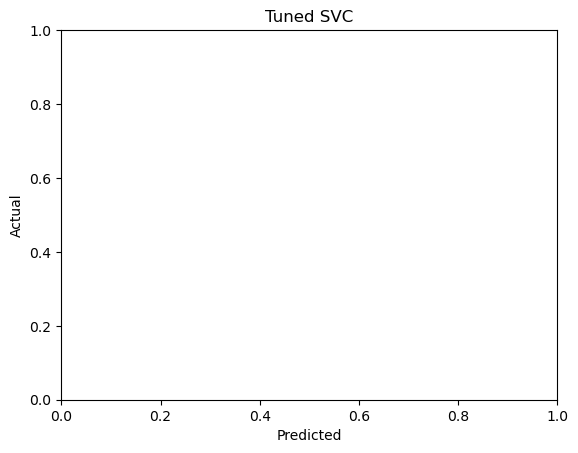

In [ ]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    ax=ax,
    xticklabels=["Real", "Fake"],
    yticklabels=["Real", "Fake"],
    cmap="Blues",
)
plt.title("Tuned SVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")